In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
#notify=Audio(url = url, autoplay = True)
notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [62]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.5

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*2.5
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [102]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at .0422 A for 8.4 hours or until 2.2 V",
            "Charge at .1 A for 15 hours or until 2.4 V"
        ),
    ],
)


model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": 0.0422,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        "Standard Potential L [V]": 1.9,
        "Standard Potential M [V]": 1.95,
        "Standard Potential H [V]": 2.35,
        "Lower voltage cut-off [V]" : 2.0
        
    }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        dt_max = 10,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = .5
time_in_seconds = 3600*hours
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

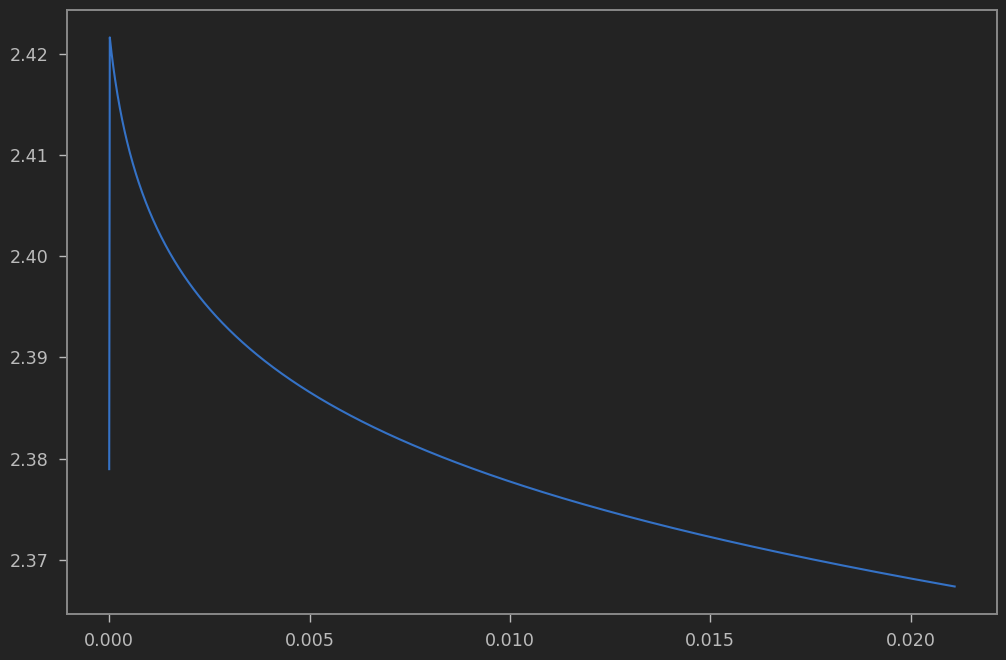

In [103]:
plt.plot(0.0422*sim.solution.t/3600, sim.solution["Terminal voltage [V]"].entries)

In [104]:
x = np.where(sim.solution['Terminal voltage [V]'].entries <= 2.4)
loc = x[0][1]
S8_initial = sim.solution['S8 [g]'].entries[loc]
S6_initial = sim.solution['S6 [g]'].entries[loc]
S4_initial = sim.solution['S4 [g]'].entries[loc]
S2_initial = sim.solution['S2 [g]'].entries[loc]
S_initial = sim.solution['S [g]'].entries[loc]
Sp_initial = sim.solution["Precipitated Sulfur [g]"].entries[loc]
V_initial = sim.solution['Terminal voltage [V]'].entries[loc]

In [105]:
print(S8_initial)
print(S6_initial)
print(S4_initial)
print(S2_initial)
print(S_initial)
print(Sp_initial)
print(V_initial)

0.5994497992432309
0.014276183725582573
0.009826487256660566
7.236564451939587e-11
1.2723395454343494e-14
2.3426047241510102e-07
2.3999806024835673


In [86]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": 0.0422,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S6 ion [g]": S6_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Standard Potential L [V]": 2.0,#1.95,
        "Standard Potential M [V]": 2.0,#1.98,
        "Standard Potential H [V]": 2.38,#2.35,
        "Lower voltage cut-off [V]" : 2.0
        
    }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        dt_max = 10,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 16990#3600*hours
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

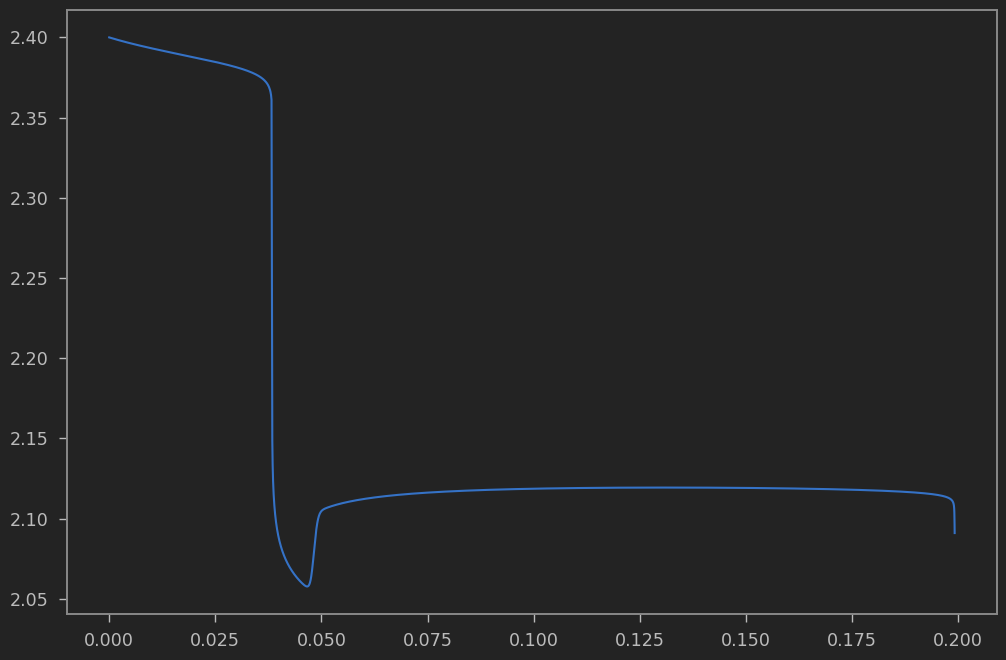

In [87]:
plt.plot(0.0422*sim.solution.t/3600, sim.solution["Terminal voltage [V]"].entries)

In [91]:
model_c = pybamm.lithium_sulfur.ZeroD_Chemistry_5()

param = model_c.default_parameter_values
param.update(
    {
        "Current function [A]": 0.0422,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S6 ion [g]": S6_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 2.0,#1.98,
        "Standard Potential H [V]": 2.38,#2.35,
        "Lower voltage cut-off [V]" : 1.8,
        "gamma" : 100,
        "kappa": 30
        
    }
)


sim_c = pybamm.Simulation(
    model_c,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        dt_max = 10,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 5
time_in_seconds = 3600*hours
sim_c.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

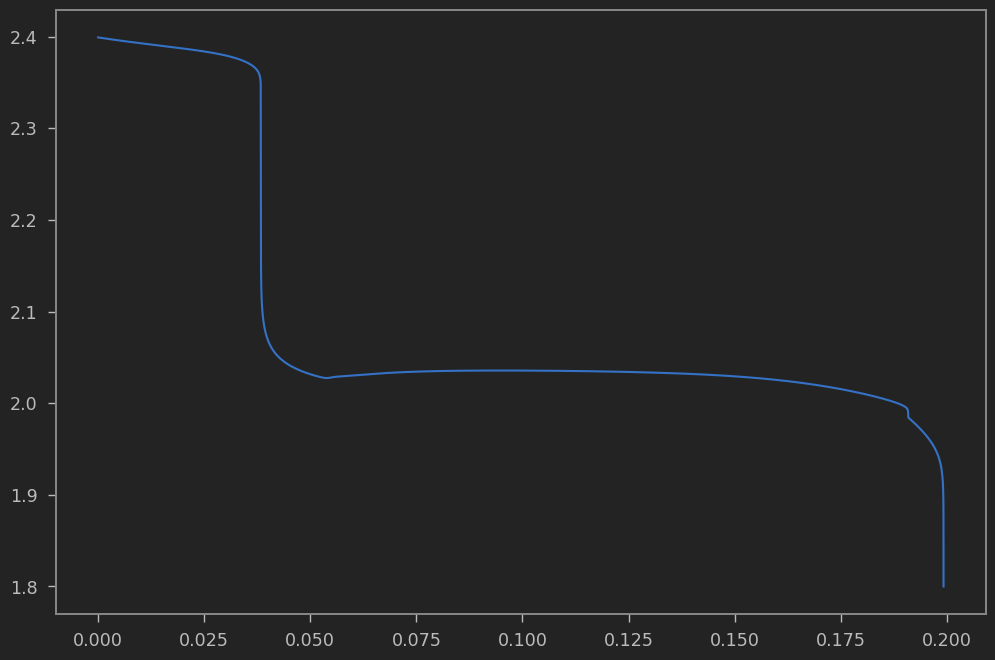

In [92]:
plt.plot(0.0422*sim_c.solution.t/3600, sim_c.solution["Terminal voltage [V]"].entries)

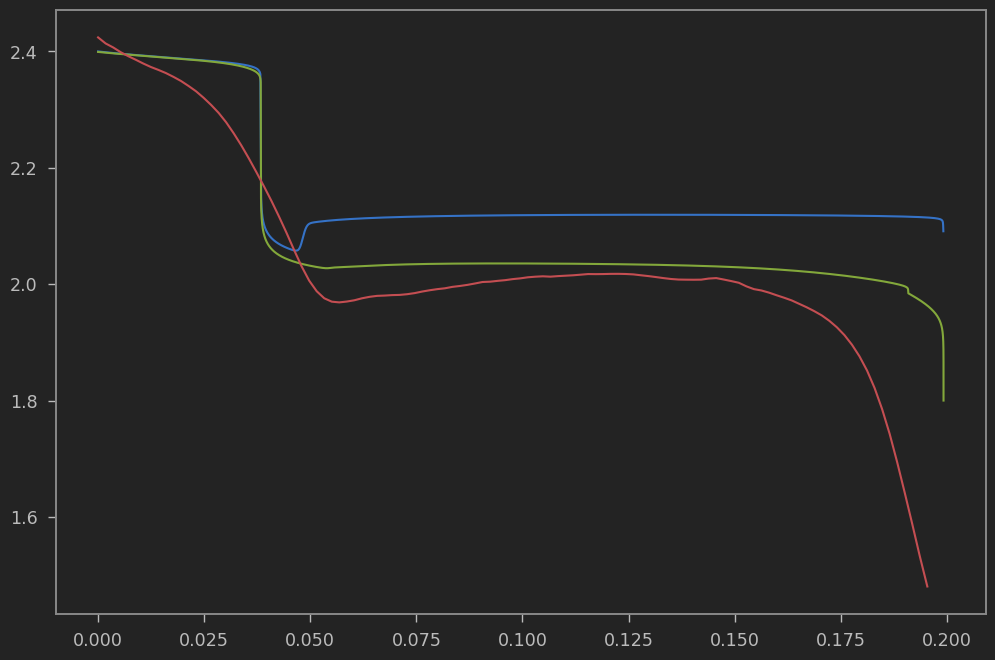

In [93]:
plt.plot(0.0422*sim.solution.t/3600, sim.solution["Terminal voltage [V]"].entries)
plt.plot(0.0422*sim_c.solution.t/3600, sim_c.solution["Terminal voltage [V]"].entries)
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])